In [348]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# The QUEST

In [349]:
# ADAM NOTE: leaving this as a help table for future

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [350]:
# Unified Imports cell 
# (Adam note: I won't let the mess from the previous merge notebook happen again)

import os
from os import remove
from pickletools import optimize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFilter
# from tensorflow.keras.preprocessing.image import ImageDataGenerator DEPRECATED
from pathlib import Path
import kagglehub
import math
import tensorflow as tf
import torch.nn as nn
from fontTools.misc.bezierTools import cubicPointAtTC
from torch import optim
from PIL import Image
import wandb
from sklearn.model_selection import train_test_split

# ### Adam Candrák/Mária Matušisková - 50%/50%

-------------------------------------------------------------------------------------------
## Image classification 
-------------------------------------------------------------------------------------------

As the quest we wan't to tackle, we choose- "3 Way Classification - COVID-19, Viral Pneumonia, Normal" from the dataset provided by the [Covid-19 Image Dataset](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset/data). The dataset contains 3 types of images: COVID-19, Viral Pneumonia and Normal. The dataset is already divided into training and testing sets. Each of these folders is divided into 3 folders, each containing images of one of the types. 

The training set contains **251** images and the testing set contains **66** images.

The goal is to create a model that will be able to classify the images into one of the three categorie.

Data download:

In [351]:
# Download latest version
path = kagglehub.dataset_download("pranavraikokte/covid19-image-dataset")

print("Path to dataset files:", path)


100%|██████████| 158M/158M [00:04<00:00, 34.2MB/s] 

Extracting files...


Path to dataset files: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2


-------------------------------------------------------------------------------------------
## 4.1 EDA
-------------------------------------------------------------------------------------------
First let's take a look at the data. W some images will loadm in a grid.

In [352]:
TRAIN_PATH = os.path.join(path, 'Covid19-dataset', 'train')
TEST_PATH = os.path.join(path, 'Covid19-dataset', 'test')
# method source: 'https://www.kaggle.com/code/justicevil/covid19-image-classification-vgg16-val-acc-98' the is ImageDataGenerator deprecated
# so we will replace it's function with something current

height, width = 227, 227
batch_size = 16
class_names = ['Normal', 'Viral Pneumonia', 'Covid']

def create_dataset(path):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        # resize images
        image_size=(height, width),
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        label_mode='categorical',
        class_names=class_names,
        color_mode='grayscale'
    )

    # optimise performance for training
    ds = ds.cache().shuffle(1000)
    # it is friendly to PC resources
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    # rescale pixel values
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y))
    
    return ds

train_ds = create_dataset(TRAIN_PATH)
test_ds = create_dataset(TEST_PATH)

# extract labels 
## CLAUDE.AI (because of the error out of range)
def get_labels(dataset):
    labels = []
    for _, y in dataset.as_numpy_iterator():
        labels.append(y)
    return np.concatenate(labels)
##

train_labels = get_labels(train_ds)
test_ds_labels = create_dataset(TEST_PATH) 
test_labels = get_labels(test_ds_labels)
all_labels = np.concatenate([train_labels, test_labels])

print(f"Total number of images: ", len(all_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(all_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")

print(f"\n\nTotal number of images for training: ", len(train_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(train_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Found 66 files belonging to 3 classes.
Total number of images:  317
Normal cases: 90
Viral Pneumonia cases: 90
Covid cases: 137


Total number of images for training:  251
Normal cases: 70
Viral Pneumonia cases: 70
Covid cases: 111


The main function of this code is:
1. Images are resized to 224x224 pixels and rescaled to [0,1] range
2. Uses batch size of 64
3. Assigns one-hot encoding for labels (|1|0|0| - normal, |0|1|0| - pneu, |0|0|1| - covid)
4. Enables shuffling with fixed random seed (42)

Let's now graphicly show some data to visualy inspect.

In [353]:
def plot_images(ds):
    ds = ds.repeat()
    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        for i in range(16):
            plt.subplot(4, 4, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[np.argmax(labels[i])])
            plt.axis('off')
    plt.show()

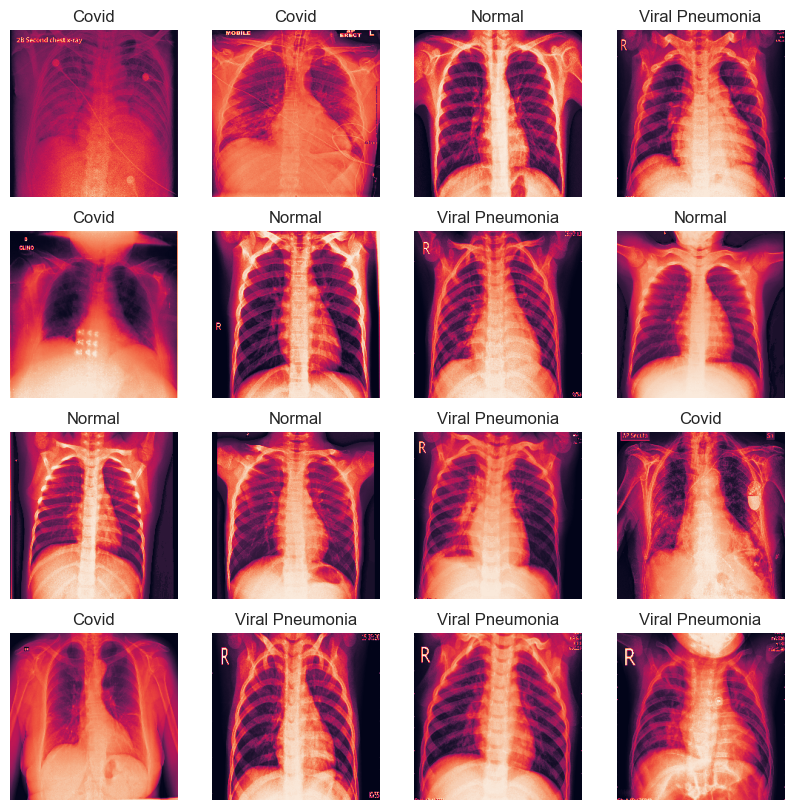

In [354]:
plot_images(train_ds)

Now we can see that all the images are standardised and seem to look similar. But from the public notebook "[COVID19 image classification VGG16 val-acc: 98%](https://www.kaggle.com/code/justicevil/covid19-image-classification-vgg16-val-acc-98)"
 we can see that augmenting (changing the image position, rotation and scale) might be beneficial and might help in increasing the models generalisation and therefore, accuracy.
 
#### Data preprocessing

In the next phase we can eather compare models fitted with unaugmented and augmented images or add these augmented images to ones that are unagmented to encrease the sample size."

In [355]:
def augment_dataset(path):
    ds = tf.keras.utils.image_dataset_from_directory(
        path,
        image_size=(height, width),
        batch_size=batch_size,
        shuffle=True,
        seed=42,
        label_mode='categorical',
        class_names=class_names
    )

    aug = tf.keras.Sequential([
       tf.keras.layers.RandomFlip("horizontal"),
       # tf.keras.layers.RandomTranslation(0.1, 0.1, fill_mode="constant", fill_value=0.0), # this augmentation seems to be too disruptive (might try later) 
       tf.keras.layers.RandomRotation(20/360, fill_mode="constant", fill_value=0.0), # 20 stupňov
       tf.keras.layers.RandomZoom(0.15, fill_mode="constant", fill_value=0.0),
    # Let's get images to the same size. It normalizes pixel values from 0-255 (RGB) to 0-1 (grayscale). This is more effective for training.
       tf.keras.layers.Rescaling(1./255),
       tf.keras.layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x))
   ])

    ds = ds.map(lambda x, y: (aug(x), y))
    ds = ds.cache().shuffle(1000)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return ds


train_ds_aug = augment_dataset(TRAIN_PATH)
test_ds_aug = augment_dataset(TEST_PATH)

Found 251 files belonging to 3 classes.
Found 66 files belonging to 3 classes.


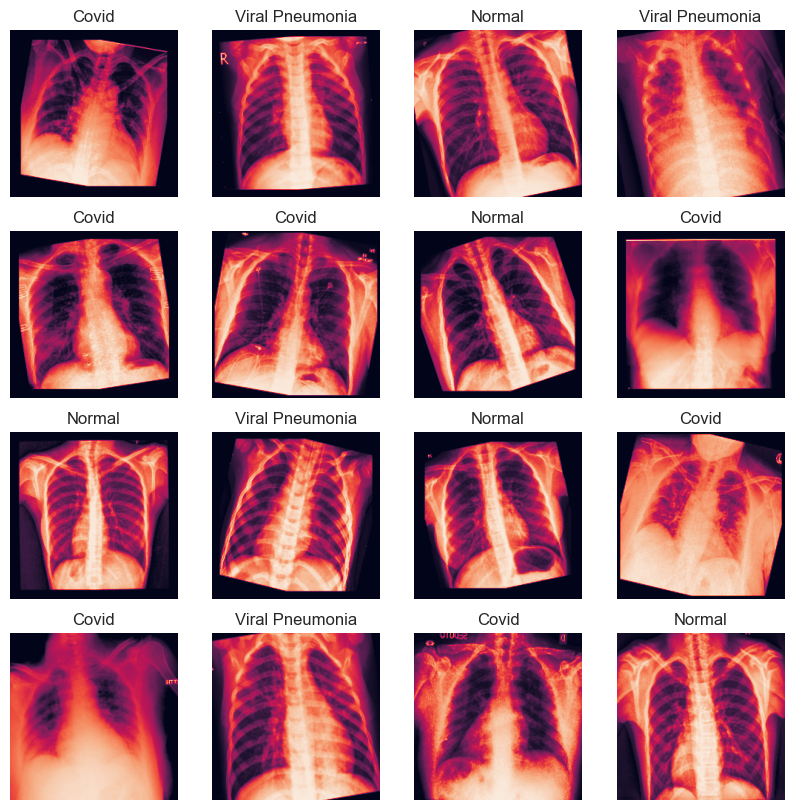

In [356]:
plot_images(train_ds_aug)

#### Manual searching for outliers in the training dataset

Function for plotting outliers

In [357]:
def plot_outlier_images(image_paths):
    plt.figure(figsize=(10, 10))
    for img, path in enumerate(image_paths):
        image = tf.keras.utils.load_img(path, target_size=(height, width))
        plt.subplot(4, 4, img + 1)
        plt.imshow(image, cmap="gray")
        plt.title(f'{path.split('/')[-1]}')
        plt.axis('off')
    plt.show()

Covid - training

- We chose these outliers:

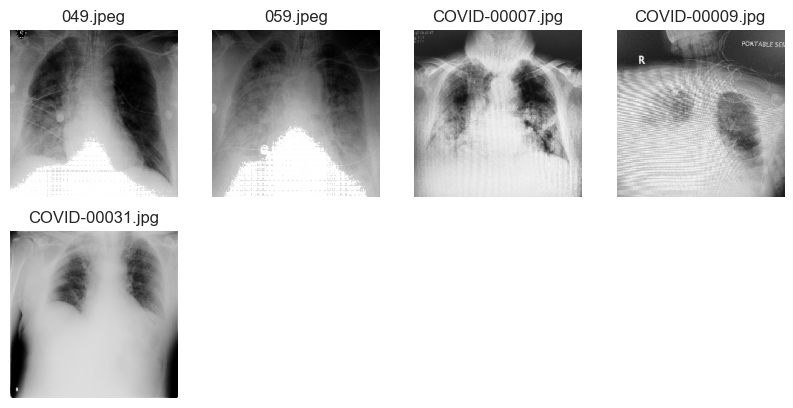

In [358]:
COVID_49 = os.path.join(TRAIN_PATH, 'Covid', '049.jpeg')
COVID_59 = os.path.join(TRAIN_PATH, 'Covid', '059.jpeg')
COVID_00007 = os.path.join(TRAIN_PATH, 'Covid', 'COVID-00007.jpg')
COVID_00009 = os.path.join(TRAIN_PATH, 'Covid', 'COVID-00009.jpg')
COVID_000031 = os.path.join(TRAIN_PATH, 'Covid', 'COVID-00031.jpg')

outliers_covid = [
    COVID_49,
    COVID_59,
    COVID_00007,
    COVID_00009,
    COVID_000031,
]

plot_outlier_images(outliers_covid)

Normal - training
- they were visibly different compare to other images

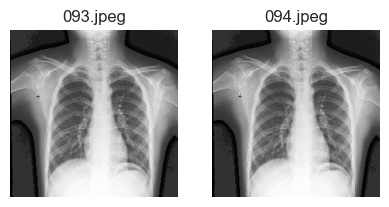

In [359]:
NORMAL_93 = os.path.join(TRAIN_PATH, 'Normal', '093.jpeg')
NORMAL_94 = os.path.join(TRAIN_PATH, 'Normal', '094.jpeg')

outliers_normal = [
    NORMAL_93,
    NORMAL_94,
]

plot_outlier_images(outliers_normal)

Viral Pneumonia - training
- the posture looks difficult for training

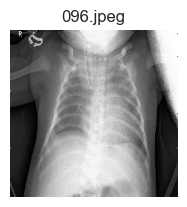

In [360]:
VIRAL_PNEUMONIA_96 = os.path.join(TRAIN_PATH, 'Viral Pneumonia', '096.jpeg')

outliers_viral_pneumonia = [
    VIRAL_PNEUMONIA_96
]

plot_outlier_images(outliers_viral_pneumonia)

Let's remove them. Firstly create path to images:

In [361]:
# with help of Claude.AI
def create_dataset_dict(path):
    class_image_paths = {}

    for class_name in os.listdir(path):
        class_folder = os.path.join(path, class_name)
        
        image_paths = [
            os.path.join(class_folder, f)
            for f in os.listdir(class_folder)
            if f.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        class_image_paths[class_name] = image_paths

    return class_image_paths
##

train_img_paths = create_dataset_dict(TRAIN_PATH)
test_img_paths = create_dataset_dict(TEST_PATH)

In [362]:
# with help of chatgpt
def remove_outliers(dataset_paths, outlier_paths):
    outliers_set = set(outlier_paths)

    for class_name, paths in dataset_paths.items():
        print(f"Before filtering {class_name}: {len(paths)} images")
        filtered_paths = [path for path in paths if path not in outliers_set]

        for path in paths:
            if path not in filtered_paths:  
                try:
                    os.remove(path) 
                    print(f"Removed: {path}")
                except Exception as e:
                    print(f"Error removing {path}: {e}")

        dataset_paths[class_name] = filtered_paths
        print(f"After filtering {class_name}: {len(filtered_paths)} images")

    return dataset_paths
#

train_img_paths = remove_outliers(train_img_paths, outliers_covid)
print()
train_img_paths = remove_outliers(train_img_paths, outliers_normal)
print()
train_img_paths = remove_outliers(train_img_paths, outliers_viral_pneumonia)

Before filtering Viral Pneumonia: 70 images
After filtering Viral Pneumonia: 70 images
Before filtering Normal: 70 images
After filtering Normal: 70 images
Before filtering Covid: 111 images
Removed: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Covid/COVID-00007.jpg
Removed: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Covid/049.jpeg
Removed: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Covid/COVID-00031.jpg
Removed: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Covid/COVID-00009.jpg
Removed: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Covid/059.jpeg
After filtering Covid: 106 images

Before filtering Viral Pneumonia: 70 images
After filtering Viral Pneumonia: 70 images
B

The images have inconsistent format jpg, jpeg and png. Let's convert them into png.


In [363]:
def to_png(img_paths, output_dir):
    converted_img_paths = []
    for class_name, img_paths in img_paths.items():
        class_dir = os.path.join(output_dir, class_name)
        for img_path in img_paths:
            with Image.open(img_path) as img:
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                new_img_path = os.path.join(class_dir, base_name + '.png')
                img.save(new_img_path, 'PNG')
                converted_img_paths.append(new_img_path)
                print(f"Converted to {new_img_path}")
                os.remove(img_path)
                print(f"Removed original image: {img_path}")
            
    return converted_img_paths

train_img_paths = to_png(train_img_paths, TRAIN_PATH)
test_img_paths = to_png(test_img_paths, TEST_PATH)
    

Converted to /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Viral Pneumonia/06.png
Removed original image: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Viral Pneumonia/06.jpeg
Converted to /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Viral Pneumonia/037.png
Removed original image: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Viral Pneumonia/037.jpeg
Converted to /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Viral Pneumonia/076.png
Removed original image: /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/versions/2/Covid19-dataset/train/Viral Pneumonia/076.jpeg
Converted to /Users/maria/.cache/kagglehub/datasets/pranavraikokte/covid19-image-dataset/v

### After these changes, we need to recreate datasets:

In [364]:
train_ds = create_dataset(TRAIN_PATH)
test_ds = create_dataset(TEST_PATH)

train_labels = get_labels(train_ds)
test_ds_labels = create_dataset(TEST_PATH)
test_labels = get_labels(test_ds_labels)
all_labels = np.concatenate([train_labels, test_labels])

print(f"Total number of images: ", len(all_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(all_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")

print(f"\n\nTotal number of images for training: ", len(train_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(train_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")


Found 235 files belonging to 3 classes.
Found 63 files belonging to 3 classes.
Found 63 files belonging to 3 classes.
Total number of images:  298
Normal cases: 88
Viral Pneumonia cases: 89
Covid cases: 121


Total number of images for training:  235
Normal cases: 68
Viral Pneumonia cases: 69
Covid cases: 98


In [365]:
train_ds_aug = augment_dataset(TRAIN_PATH)
test_ds_aug = augment_dataset(TEST_PATH)

Found 235 files belonging to 3 classes.
Found 63 files belonging to 3 classes.


After looking at some rather disturbing images let's take a look at mean of each of the classes. We might see some paterns that a CNN might learn.

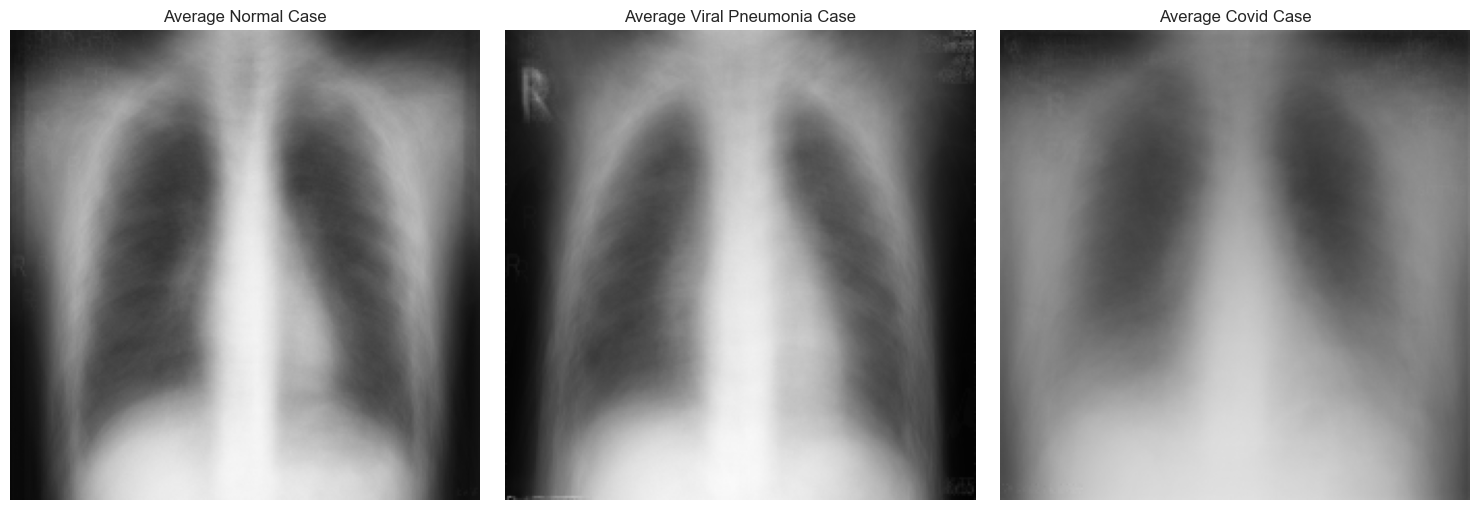

In [366]:
class_sums = {name: None for name in class_names}
class_counts = {name: 0 for name in class_names}

# base black zero image
for c_name in class_names:
    class_sums[c_name] = tf.zeros(shape=(227, 227, 3))

for images, labels in train_ds.as_numpy_iterator():
    for img, label in zip(images, labels):
        class_id = tf.argmax(label)

        class_sums[class_names[class_id]] += img
        class_counts[class_names[class_id]] += 1

mean_img = [None] * 3
for id, class_name in enumerate(class_names):
    mean_img[id] = class_sums[class_name] / class_counts[class_name]

plt.figure(figsize=(15, 5))
for id, class_name in enumerate(class_names):
    plt.subplot(1, 3, id + 1)
    plt.imshow(mean_img[id].numpy())
    plt.title(f'Average {class_name} Case')
    plt.axis('off')

plt.tight_layout()
plt.show()

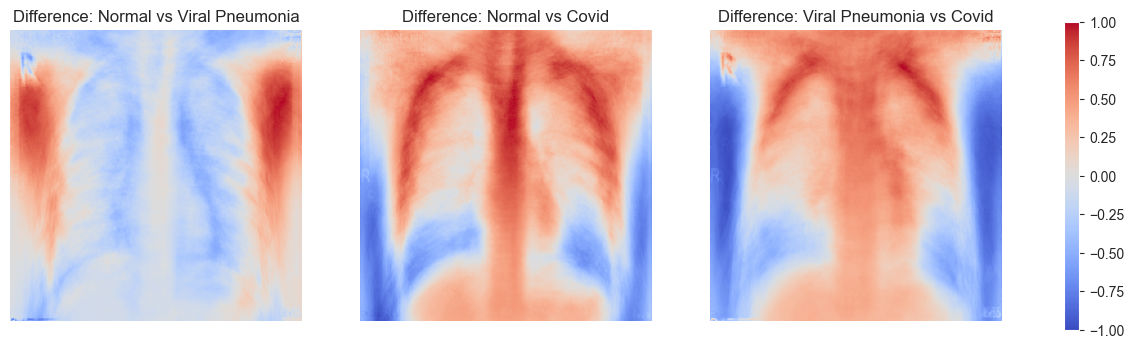

In [367]:
# here we can change the colors to match the images and colorbar
cmap = 'coolwarm'

fig = plt.figure(figsize=(16, 5))
plot_id = 1
for i, class_1 in enumerate(class_names):
    for j, class_2 in enumerate(class_names):
        if i >= j:
            continue
            
        difference = mean_img[i] - mean_img[j]
        
        # took me like one hour to figgure out that plt was confused and thought the image is RGB :)
        difference = tf.reduce_mean(difference, axis=-1) 
        
        fig.add_subplot(1, 3, plot_id)
        plt.imshow(difference.numpy(), cmap=cmap)
        plt.title(f'Difference: {class_1} vs {class_2}')
        plt.axis('off')
        plot_id += 1
        
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(-1, 1), cmap=cmap), ax=fig.axes, orientation='vertical', shrink=0.8)
plt.show()


From this testing we can see that there are some significant difference in the intensity of pixels in each of the classes. These are features that a CNN can pick up on an learn from them.

For this task we chose to use **AlexNet** for our classification task.

### AlexNet

AlexNet was one of the pioneering CNN architectures that demonstrated the potential of deep learning for image classification by winning the 2012 ImageNet competition. Its structure is well-suited for extracting hierarchical features from images.

Compared to more recent architectures (e.g., ResNet or VGG), AlexNet has a simpler design and lower computational requirements, making it a good choice for smaller datasets and 2 week school project :)

-------------------------------------------------------------------------------------------
## 4.2 Modeling and evaluation
-------------------------------------------------------------------------------------------


### AlexNet

AlexNet is using activation function ReLU in CNN, the advantage of it that ReLU performs faster than tanh or sigmoid networks.
- Standarization
    - After ReLU the values have different range so the normalization is needed after that-> LRU (Local Response Norm)
- Dropout
    - Prevents overfitting of CNN (convolutional neural networks). It modifies the structure of the neural network itself. For some layers it randomly deletes some neurons with specific probability.

Now, let's create AlexNet Model,
     to construct it, we will use this picture as a plan:
        ![alt text](alexnet2.png "Image")

In [368]:
# Sources: 
# https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
# https://github.com/dansuh17/alexnet-pytorch/blob/d0c1b1c52296ffcbecfbf5b17e1d1685b4ca6744/model.py#L40
# https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
# https://www.digitalocean.com/community/tutorials/alexnet-pytorch

class AlexNetModel(nn.Module):
    def __init__(self):
        super(AlexNetModel, self).__init__()
        
        # NET Part
        self.layer1 = nn.Sequential(
            #  output will be: (96 x 55 x 55)
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            # As I mentioned after ReLU is coming normalization
            # from the paper the values are k = 2, n = 5, alpha = 10^-4, beta = 0.75
            nn.LocalResponseNorm(k=2, size=5, alpha=0.0001, beta=0.75),
            # output from the layer (in others comments like this is the same - not the size) (96 x 27 x 27)
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            # output (256 x 27 x 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(k=2, size=5, alpha=0.0001, beta=0.75),
            # output (256 x 13 x 13)
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.layer3 = nn.Sequential(
            # output (384 x 13 x 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.layer4 = nn.Sequential(
            # output (384 x 13 x 13) (not serious note: this layer is similar to unet a little bit like a bridge, because firstly the channels are increasing and then decreasing (but only one layer after this one) after this layer and this is the stable line between it)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.layer5 = nn.Sequential(
            # output (256 x 13 x 13)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            # output (256 x 6 x 6)
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # now classifier (linear layer): 
        self.fc1 = nn.Sequential(
            # p -> probability
            nn.Dropout(p=0.5, inplace=False),
            # in features = last output
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU()
        )
        
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=3),
        )
        # 
        # self.softmax_layer = nn.Sequential(
        #     # we have three classes (covid, normal, viral pneumonia) so output will be 3
        #     nn.Linear(in_features=1000, out_features=3),
        #     nn.Softmax(dim=1),
        # )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # x = self.softmax_layer(x)
        return x

### Split dataset into train and val

In [369]:
# with help of Claude.AI
def split_dataset(dataset, train_size=0.8, shuffle=True, seed=42):
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    train_size = int(train_size * dataset_size)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=dataset_size, seed=seed)

    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)

    return train_dataset, val_dataset

split_train_ds, val_ds = split_dataset(train_ds, train_size=0.8)
##


split_train_labels = get_labels(split_train_ds)
val_labels = get_labels(val_ds)
all_labels = np.concatenate([split_train_labels, val_labels, test_labels], axis=0)

print(f"Total number of images: ", len(all_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(all_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")

print(f"\n\nTotal number of images for training: ", len(split_train_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(split_train_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")

print(f"\n\nTotal number of images for training: ", len(val_labels))
for i, class_name in enumerate(class_names):
    count = np.sum(np.argmax(val_labels, axis=1) == i)
    print(f"{class_name} cases: {count}")
    
## for augmented dataset

split_train_ds_aug, val_ds_aug = split_dataset(train_ds_aug, train_size=0.8)

split_train_labels_aug = get_labels(split_train_ds_aug)
val_labels_aug = get_labels(val_ds_aug)
all_labels_aug = np.concatenate([split_train_labels_aug, val_labels_aug, test_labels], axis=0)


Total number of images:  298
Normal cases: 87
Viral Pneumonia cases: 91
Covid cases: 120


Total number of images for training:  187
Normal cases: 49
Viral Pneumonia cases: 57
Covid cases: 81


Total number of images for training:  48
Normal cases: 18
Viral Pneumonia cases: 14
Covid cases: 16


Let's set hyperparametres. The batch size is already set in the upper code to 64. We need:
-  the number of classes 
-  number of epochs
- learning rate
- loss criterion
- optimizer  

In [370]:
num_classes = 3
num_epochs = 10
learning_rate = 0.001
loss_criterion = nn.CrossEntropyLoss()
model = AlexNetModel()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

### Make a dataset

We think that labels, which were from get_labels will be unused from this part of training. The reason is, that labels are already in the created dataset -> for example: split_train_ds

Also we tried to work with keras and PyTroch. In this part it should be only PyTorch

Firstly we will create a class for Dataset, and convert data into simplier format for training:

In [371]:
import torch
from torch.utils.data import Dataset, DataLoader


class COVID_Dataset(Dataset):
    def __init__(self, created_dataset):
        self.images = []
        self.labels = []

        # iterator to prevent to go out of range
        for images, labels in created_dataset.as_numpy_iterator():
            self.images.extend(images) 
            self.labels.extend(labels)  

        # convert lists to numpy arrays for easier training
        self.images = np.array(self.images)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.FloatTensor(self.images[idx])

        ### with help of Claude.AI due to error
        # convert one-hot label to class index
        label = np.argmax(self.labels[idx])
        label = torch.tensor(label, dtype=torch.long)

        # (C, H, W) format -> Channel, Height, Width
        image = image.permute(2, 0, 1)
        ###

        return image, label

create dataset for each part
   - training
   - validation
   - testing 

then place dataset into loader with a batch size to running through it during training
    

In [372]:
train_dataset_aug = COVID_Dataset(split_train_ds_aug)
val_dataset_aug = COVID_Dataset(val_ds_aug)
test_dataset_aug = COVID_Dataset(test_ds)

train_loader_aug = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=False)
test_loader_aug = DataLoader(test_dataset_aug, batch_size=batch_size, shuffle=False)

# Claude.AI
# print for check
print(f"Number of training batches: {len(train_loader_aug)}")
print(f"Number of validation batches: {len(val_loader_aug)}")
print(f"Number of test batches: {len(test_loader_aug)}")

for images, labels in train_loader_aug:
    print(f"Batch images shape: {images.shape}") 
    print(f"Batch labels shape: {labels.shape}")  
    break
##

Number of training batches: 12
Number of validation batches: 3
Number of test batches: 4
Batch images shape: torch.Size([16, 1, 227, 227])
Batch labels shape: torch.Size([16])


The same, but for not augmented dataset:

In [373]:
train_dataset = COVID_Dataset(split_train_ds)
val_dataset = COVID_Dataset(val_ds)
test_dataset = COVID_Dataset(test_ds)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Claude.AI
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break
##

Number of training batches: 12
Number of validation batches: 3
Number of test batches: 4
Batch images shape: torch.Size([16, 1, 227, 227])
Batch labels shape: torch.Size([16])


Calculate length of dataset and batch num for each part:

In [374]:
train_data_num_aug = len(train_dataset_aug)
val_data_num_aug = len(val_dataset_aug)
# Total number of samples in the test dataset.
test_data_num_aug = len(test_dataset_aug)

train_batch_num_aug = int(np.ceil(train_data_num_aug / batch_size))
val_batch_num_aug = int(np.ceil(val_data_num_aug / batch_size))
# The total number of batches for testing, calculated by dividing the number of test samples by the batch size.
test_batch_num_aug = int(np.ceil(test_data_num_aug / batch_size))

The same, but for not augmented dataset:

In [375]:
train_data_num = len(train_dataset)
val_data_num = len(val_dataset)
# Total number of samples in the test dataset.
test_data_num = len(test_dataset)

train_batch_num = int(np.ceil(train_data_num / batch_size))
val_batch_num = int(np.ceil(val_data_num / batch_size))
# The total number of batches for testing, calculated by dividing the number of test samples by the batch size.
test_batch_num = int(np.ceil(test_data_num / batch_size))

#### The training and validation part:
- the logs are in the wandb

In [376]:
from torch import no_grad

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

def train_model(model, train_loader_, val_loader_, train_batch_num_, val_batch_num_):
    best_accuracy = 0.0
    wandb.watch(model, log="all")
    wandb.config.update({
        "epochs": num_epochs,
        "batch_size": batch_size,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    # Each epoch runs through the entire dataset using mini-batches.
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()
        train_loss = []
        running_train_loss = 0.0

        correct = 0
        total = 0

        # train loop
        for batch_idx, (images, labels) in enumerate(train_loader_):
            image, label = images, labels
            # print(f"Image shape: {image.shape}")
            # print(f"Label shape: {label.shape}")

            if len(label.shape) > 1 and label.shape[1] > 1: 
                label = torch.argmax(label, dim=1)

            # reset gradients
            optimizer.zero_grad()
            
            # generate predictions
            predictions = model(image)
    
            # calculate loss
            loss = loss_criterion(predictions, label)
    
            # update weights and biases, compute gradients
            loss.backward()
            optimizer.step()
    
            # save data and print results
            running_train_loss += loss.item()
            train_loss.append(loss.item())

            # Claude.AI
            _, predicted = torch.max(predictions.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            ##
            
            wandb.log({"train_loss": loss.item(), "epoch": epoch + 1, "batch": batch_idx + 1})
            print_form = '[Train] | Epoch: {:0>2d} / {:0>2d} | Batch: {:0>2d} / {:0>2d} | Loss: {:.4f}'
            print(print_form.format(epoch, num_epochs, batch_idx, train_batch_num_, train_loss[-1]))
            
        train_loss_avg = np.mean(train_loss)
        train_accuracy = 100 * correct / total
        wandb.log({"avg_train_loss": train_loss_avg})

        correct = 0
        total = 0

        # validation loop
        with no_grad():
            model.eval()
            val_loss = []
    
            for batch_idx, (images, labels) in enumerate(val_loader_):
                image, label = images, labels

                if len(label.shape) > 1 and label.shape[1] > 1:  
                    label = torch.argmax(label, dim=1)
    
                # generate predictions
                predictions = model(image)
    
                # calculate loss
                loss = loss_criterion(predictions, label)
    
                # save data and print results
                val_loss.append(loss.item())
                wandb.log({"val_loss": loss.item(), "epoch": epoch + 1, "batch": batch_idx + 1})
                print_form = '[Validation] | Epoch: {:0>2d} / {:0>2d} | Batch: {:0>2d} / {:0>2d} | Loss: {:.4f}'
                print(print_form.format(epoch, num_epochs, batch_idx, val_batch_num_, val_loss[-1]))

                # Claude.AI
                _, predicted = torch.max(predictions.data, 1)
                total += label.size(0)  
                correct += (predicted == label).sum().item()
                ##
    
            val_loss_avg = np.mean(val_loss)
            wandb.log({"avg_val_loss": val_loss_avg})
    
            print_form = '[Epoch {:0>2d}] Training Avg Loss: {:.4f} | Validation Avg Loss: {:.4f}'
            print(print_form.format(epoch, train_loss_avg, val_loss_avg))

        val_accuracy = 100 * correct / total

        wandb.log({
            "epoch": epoch + 1,
            "avg_train_loss": train_loss_avg,
            "avg_val_loss": val_loss_avg,
            "train_accuracy": train_accuracy,
            "validation_accuracy": val_accuracy
        })

        training_losses.append(train_loss_avg)
        validation_losses.append(val_loss_avg)
        training_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss_avg:.4f}')
        print(f'Validation Loss: {val_loss_avg:.4f}')
        print(f'Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

        # Claude.AI
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "model.pth")
            wandb.save("model.pth")
        ##


## Generated with Claude.AI additional graph except of wandb
import matplotlib.pyplot as plt

def plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies):
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, 'b-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
##

#### Evaluation part

In [377]:
def eval_model(model, test_loader_, test_batch_num_):
    # evaluation loop
    correct = 0
    total = 0
    with no_grad():
        model.eval()
        test_loss = []
    
        for batch_idx, (images, labels) in enumerate(test_loader_):
            image, label = images, labels
    
            # generate predictions
            predictions = model(image)
    
            # calculate loss
            loss = loss_criterion(predictions, label)
    
            # save data and print results
            test_loss.append(loss.item())
            wandb.log({"eval_loss": loss.item(), "batch": batch_idx + 1})
            print_form = '[Test] | Batch: {:0>2d} / {:0>2d} | Loss: {:.4f}'
            print(print_form.format(batch_idx, test_batch_num_, test_loss[-1]))

            # Claude.AI
            _, predicted = torch.max(predictions.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            ##

    test_accuracy = 100 * correct / total
    print_form = '[Result] | Avg Loss: {:0.4f}'
    print(print_form.format(np.mean(test_loss)))
    wandb.log({"avg_val_loss": print_form.format(np.mean(test_loss))})
    print(test_accuracy)

### Model with Augmented Dataset

In [378]:
wandb.login(key='6de1d2737f3995070b7f2279edf0cbb173070efd')
wandb.init(project="iau-covid")
train_model(model, train_loader_aug, val_loader_aug, train_batch_num_aug, val_batch_num_aug)
eval_model(model, test_loader_aug, test_batch_num_aug)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


avg_train_loss,██▃▃▃▃▂▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
avg_val_loss,██▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁
batch,▃▅▄▄▆▂▃▅▂▃▁▇▂▅▁▅▄▇▅▅▃▄▁█▃▇▁▇▃▂▅▁▁▃▃▁▅▁▇▅
epoch,▁▁▁▁▃▅▅▆▆▆█████▁▁▁▃▃▅▅▅▆▆▆█▁▁▁▃▃▃▅▅▁▁▁▃▃
eval_loss,▂▅█▂▁▇▆▃
train_accuracy,▁█▇▃
train_loss,█▂▂▂▂▂▂▂▃▂▂▁▂▂▁▂▁▁▁▁▂▂▁▁▃▂▁▁▂▂▁▂▁▁▁▁▁▁▁▁
val_loss,▂▇██▄▁▁▂▁▂▂▂▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂
validation_accuracy,▁▇▇█▇▇▇▇▇█▇███
avg_train_loss,0.57711
avg_val_loss,0.57188


[Train] | Epoch: 00 / 10 | Batch: 00 / 12 | Loss: 1.0993
[Train] | Epoch: 00 / 10 | Batch: 01 / 12 | Loss: 1.2697
[Train] | Epoch: 00 / 10 | Batch: 02 / 12 | Loss: 1.1227
[Train] | Epoch: 00 / 10 | Batch: 03 / 12 | Loss: 1.1844
[Train] | Epoch: 00 / 10 | Batch: 04 / 12 | Loss: 1.1155
[Train] | Epoch: 00 / 10 | Batch: 05 / 12 | Loss: 1.1125
[Train] | Epoch: 00 / 10 | Batch: 06 / 12 | Loss: 1.0894
[Train] | Epoch: 00 / 10 | Batch: 07 / 12 | Loss: 1.1021
[Train] | Epoch: 00 / 10 | Batch: 08 / 12 | Loss: 1.1185
[Train] | Epoch: 00 / 10 | Batch: 09 / 12 | Loss: 1.1651
[Train] | Epoch: 00 / 10 | Batch: 10 / 12 | Loss: 1.0936
[Train] | Epoch: 00 / 10 | Batch: 11 / 12 | Loss: 1.0955
[Validation] | Epoch: 00 / 10 | Batch: 00 / 03 | Loss: 1.1019
[Validation] | Epoch: 00 / 10 | Batch: 01 / 03 | Loss: 1.1063
[Validation] | Epoch: 00 / 10 | Batch: 02 / 03 | Loss: 1.0891
[Epoch 00] Training Avg Loss: 1.1307 | Validation Avg Loss: 1.0991
Epoch [1/10]
Training Loss: 1.1307
Validation Loss: 1.0991
Trai

From the result of training the accuracy is extremely low anf loss function is also not correct and high. :/
We can also see that on the plotted graphs below:

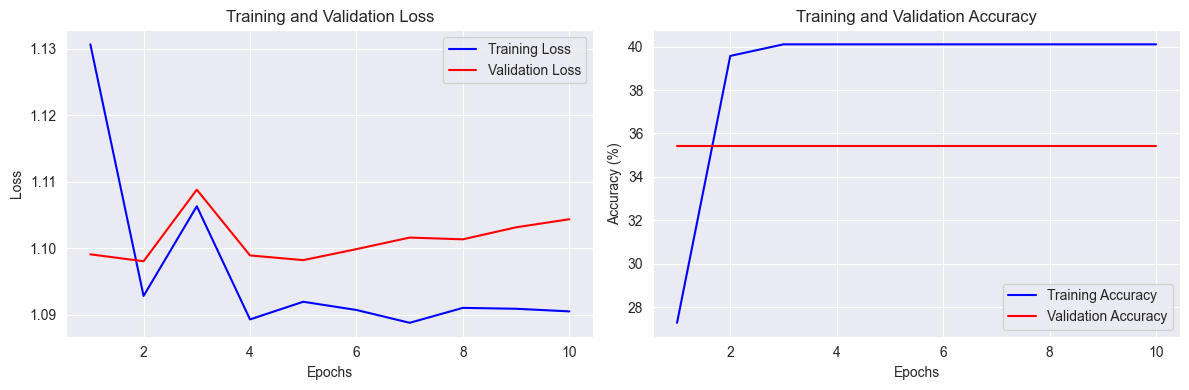

In [379]:
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)

### Model with Not Augmented Dataset

In [380]:
train_model(model, train_loader, val_loader, train_batch_num, val_batch_num)
eval_model(model, test_loader, test_batch_num)

[Train] | Epoch: 00 / 10 | Batch: 00 / 12 | Loss: 1.1157
[Train] | Epoch: 00 / 10 | Batch: 01 / 12 | Loss: 1.0356
[Train] | Epoch: 00 / 10 | Batch: 02 / 12 | Loss: 1.0395
[Train] | Epoch: 00 / 10 | Batch: 03 / 12 | Loss: 1.1381
[Train] | Epoch: 00 / 10 | Batch: 04 / 12 | Loss: 1.0956
[Train] | Epoch: 00 / 10 | Batch: 05 / 12 | Loss: 1.0945
[Train] | Epoch: 00 / 10 | Batch: 06 / 12 | Loss: 1.0522
[Train] | Epoch: 00 / 10 | Batch: 07 / 12 | Loss: 1.1129
[Train] | Epoch: 00 / 10 | Batch: 08 / 12 | Loss: 1.1310
[Train] | Epoch: 00 / 10 | Batch: 09 / 12 | Loss: 1.1115
[Train] | Epoch: 00 / 10 | Batch: 10 / 12 | Loss: 1.0280
[Train] | Epoch: 00 / 10 | Batch: 11 / 12 | Loss: 1.0222
[Validation] | Epoch: 00 / 10 | Batch: 00 / 03 | Loss: 1.1117
[Validation] | Epoch: 00 / 10 | Batch: 01 / 03 | Loss: 1.0447
[Validation] | Epoch: 00 / 10 | Batch: 02 / 03 | Loss: 1.0589
[Epoch 00] Training Avg Loss: 1.0814 | Validation Avg Loss: 1.0718
Epoch [1/10]
Training Loss: 1.0814
Validation Loss: 1.0718
Trai

The accuracy is a little bit better, but still very low.

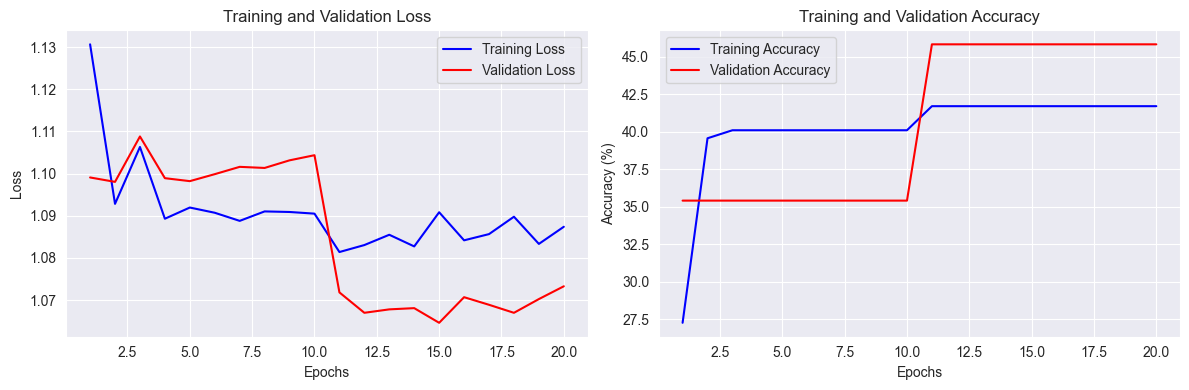

In [381]:
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)

### Improved Model

We added BatchNormalization into the model and also softmax, which converts raw output scores into probabilities

In [382]:
# Sources: 
# https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
# https://github.com/dansuh17/alexnet-pytorch/blob/d0c1b1c52296ffcbecfbf5b17e1d1685b4ca6744/model.py#L40
# https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
# https://www.digitalocean.com/community/tutorials/alexnet-pytorch

class AlexNetModel2(nn.Module):
    def __init__(self):
        super(AlexNetModel2, self).__init__()

        # NET Part
        self.layer1 = nn.Sequential(
            #  output will be: (96 x 55 x 55)
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            # As I mentioned after ReLU is coming normalization
            # from the paper the values are k = 2, n = 5, alpha = 10^-4, beta = 0.75
            nn.LocalResponseNorm(k=2, size=5, alpha=0.0001, beta=0.75),
            # output from the layer (in others comments like this is the same - not the size) (96 x 27 x 27)
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer2 = nn.Sequential(
            # output (256 x 27 x 27)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.LocalResponseNorm(k=2, size=5, alpha=0.0001, beta=0.75),
            # output (256 x 13 x 13)
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        self.layer3 = nn.Sequential(
            # output (384 x 13 x 13)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )

        self.layer4 = nn.Sequential(
            # output (384 x 13 x 13) (not serious note: this layer is similar to unet a little bit like a bridge, because firstly the channels are increasing and then decreasing (but only one layer after this one) after this layer and this is the stable line between it)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU()
        )

        self.layer5 = nn.Sequential(
            # output (256 x 13 x 13)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # output (256 x 6 x 6)
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        # now classifier (linear layer): 
        self.fc1 = nn.Sequential(
            # p -> probability
            nn.Dropout(p=0.5, inplace=False),
            # in features = last output
            nn.Linear(in_features=(256 * 6 * 6), out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(in_features=4096, out_features=1000),
            nn.BatchNorm1d(1000),
            nn.ReLU()
        )

        self.softmax_layer = nn.Sequential(
            # we have three classes (covid, normal, viral pneumonia) so output will be 3
            nn.Linear(in_features=1000, out_features=3),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.softmax_layer(x)
        return x

We also changed:
- batch size to 32
- num of epochs to 5 
- decrease learning rate to 0.0001 for slower learning
- changed AlexNetModel to AlexNetModel2

In [383]:
batch_size = 32
num_classes = 3
num_epochs = 5
learning_rate = 0.0001
loss_criterion = nn.CrossEntropyLoss()
model = AlexNetModel2()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

The previous learning in the model wasn't good due to dataset which was created by keras library. So we decided to recreated it to PyTorch dataset. In the beginning is seed for better reproducibility and randomness in the learning. It should be set before creating the datasets.

Then, we created transformation. It is a fact, that with transformation the training performs better. We transformed data into grayscale for faster and more effective learning on computer. RGB is more demanding on the computer. 

Through PyTorch ImageFolder we created datasets and also included transformations:
- train
- val
- test



In [384]:
import random
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    # common mean
    transforms.Normalize(mean=[0.485], std=[0.229])
])

full_train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=transform
)

total_size = len(full_train_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size]
)

val_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=transform
)

batch_size = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {full_train_dataset.classes}")

# verify data shapes
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Training samples: 188
Validation samples: 235
Test samples: 63
Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Batch image shape: torch.Size([16, 1, 227, 227])
Batch labels shape: torch.Size([16])


Again, calculate specific batch size for each part according to batch size:

In [385]:
train_data_num = len(train_dataset)
val_data_num = len(val_dataset)
# Total number of samples in the test dataset.
test_data_num = len(test_dataset)

train_batch_num = int(np.ceil(train_data_num / batch_size))
val_batch_num = int(np.ceil(val_data_num / batch_size))
# The total number of batches for testing, calculated by dividing the number of test samples by the batch size.
test_batch_num = int(np.ceil(test_data_num / batch_size))

Train and test model with datasets:

In [386]:
train_model(model, train_loader, val_loader, train_batch_num, val_batch_num)
eval_model(model, test_loader, test_batch_num)

[Train] | Epoch: 00 / 05 | Batch: 00 / 12 | Loss: 1.1180
[Train] | Epoch: 00 / 05 | Batch: 01 / 12 | Loss: 1.1317
[Train] | Epoch: 00 / 05 | Batch: 02 / 12 | Loss: 0.9469
[Train] | Epoch: 00 / 05 | Batch: 03 / 12 | Loss: 0.8757
[Train] | Epoch: 00 / 05 | Batch: 04 / 12 | Loss: 0.8154
[Train] | Epoch: 00 / 05 | Batch: 05 / 12 | Loss: 0.8335
[Train] | Epoch: 00 / 05 | Batch: 06 / 12 | Loss: 0.8052
[Train] | Epoch: 00 / 05 | Batch: 07 / 12 | Loss: 0.7345
[Train] | Epoch: 00 / 05 | Batch: 08 / 12 | Loss: 0.7090
[Train] | Epoch: 00 / 05 | Batch: 09 / 12 | Loss: 0.6587
[Train] | Epoch: 00 / 05 | Batch: 10 / 12 | Loss: 0.7283
[Train] | Epoch: 00 / 05 | Batch: 11 / 12 | Loss: 0.6686
[Validation] | Epoch: 00 / 05 | Batch: 00 / 15 | Loss: 0.6227
[Validation] | Epoch: 00 / 05 | Batch: 01 / 15 | Loss: 0.6225
[Validation] | Epoch: 00 / 05 | Batch: 02 / 15 | Loss: 0.6221
[Validation] | Epoch: 00 / 05 | Batch: 03 / 15 | Loss: 0.6229
[Validation] | Epoch: 00 / 05 | Batch: 04 / 15 | Loss: 0.6223
[Valid

The accuracy is much better, but the model is overfitted.
- training accuracy: 96.28%
- validation accuracy:  85.96%
- test accuracy 76.19%

There is a gap between train and test accuracy, which indicates overfit.


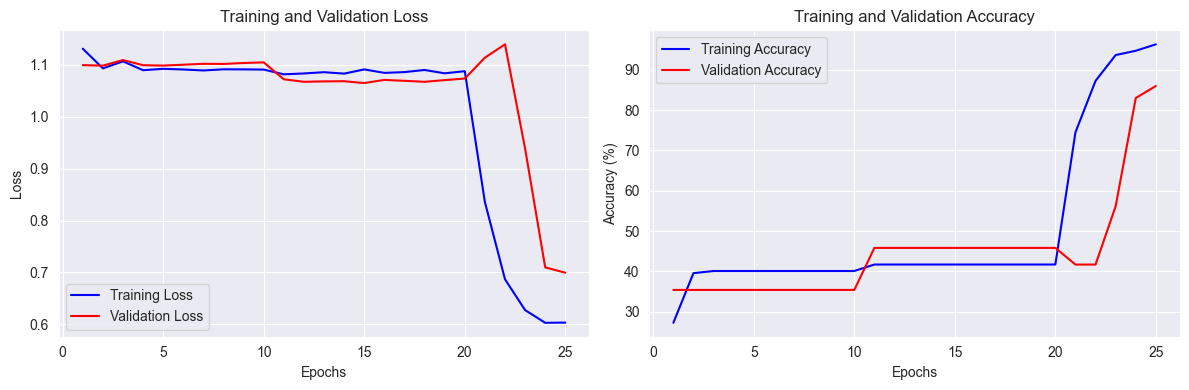

In [387]:
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)

### Last improvement of Training

Added scheduler

In [389]:
num_classes = 3
num_epochs = 5
learning_rate = 0.0001
loss_criterion = nn.CrossEntropyLoss()
model = AlexNetModel2()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    # to maximize accuracy
    mode='max',  
    # multiply learning rate by 0.1 to reduce definied learning value,
    # it is better when learning rate is dynamic
    factor=0.1,       
    # num of epoch to wait when reschedule
    patience=2
)

Added transformations

In [390]:
import random
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    # common mean 
    transforms.Normalize(mean=[0.485], std=[0.229])
])

full_train_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=transform
)

total_size = len(full_train_dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset,
    [train_size, val_size]
)

val_dataset = datasets.ImageFolder(
    root=TRAIN_PATH,
    transform=transform
)

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=transform
)

batch_size = 16

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {full_train_dataset.classes}")

# verify data shapes
for images, labels in train_loader:
    print(f"Batch image shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    break

Training samples: 188
Validation samples: 235
Test samples: 63
Classes: ['Covid', 'Normal', 'Viral Pneumonia']
Batch image shape: torch.Size([16, 1, 227, 227])
Batch labels shape: torch.Size([16])


In [391]:
train_data_num = len(train_dataset)
val_data_num = len(val_dataset)
# Total number of samples in the test dataset.
test_data_num = len(test_dataset)

train_batch_num = int(np.ceil(train_data_num / batch_size))
val_batch_num = int(np.ceil(val_data_num / batch_size))
# The total number of batches for testing, calculated by dividing the number of test samples by the batch size.
test_batch_num = int(np.ceil(test_data_num / batch_size))

In [392]:
from torch import no_grad

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

def train_model(model, train_loader_, val_loader_, train_batch_num_, val_batch_num_):
    best_accuracy = 0.0
    start_patience = 5
    patience_counter = 0
    best_model_state = None
    
    wandb.watch(model, log="all")
    wandb.config.update({
        "epochs": num_epochs,
        "batch_size": batch_size,
        "optimizer": optimizer.__class__.__name__,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    # Each epoch runs through the entire dataset using mini-batches.
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()
        train_loss = []
        running_train_loss = 0.0

        correct = 0
        total = 0

        # train loop
        for batch_idx, (images, labels) in enumerate(train_loader_):
            image, label = images, labels
            # print(f"Image shape: {image.shape}")
            # print(f"Label shape: {label.shape}")

            if len(label.shape) > 1 and label.shape[1] > 1:
                label = torch.argmax(label, dim=1)

            # reset gradients
            optimizer.zero_grad()

            # generate predictions
            predictions = model(image)

            # calculate loss
            loss = loss_criterion(predictions, label)

            # update weights and biases, compute gradients
            loss.backward()
            optimizer.step()

            # save data and print results
            running_train_loss += loss.item()
            train_loss.append(loss.item())

            # Claude.AI
            _, predicted = torch.max(predictions.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            ##

            wandb.log({"train_loss": loss.item(), "epoch": epoch + 1, "batch": batch_idx + 1})
            print_form = '[Train] | Epoch: {:0>2d} / {:0>2d} | Batch: {:0>2d} / {:0>2d} | Loss: {:.4f}'
            print(print_form.format(epoch, num_epochs, batch_idx, train_batch_num_, train_loss[-1]))

        train_loss_avg = np.mean(train_loss)
        train_accuracy = 100 * correct / total
        wandb.log({"avg_train_loss": train_loss_avg})

        correct = 0
        total = 0

        # validation loop
        with no_grad():
            model.eval()
            val_loss = []

            for batch_idx, (images, labels) in enumerate(val_loader_):
                image, label = images, labels

                if len(label.shape) > 1 and label.shape[1] > 1:
                    label = torch.argmax(label, dim=1)

                # generate predictions
                predictions = model(image)

                # calculate loss
                loss = loss_criterion(predictions, label)

                # save data and print results
                val_loss.append(loss.item())
                wandb.log({"val_loss": loss.item(), "epoch": epoch + 1, "batch": batch_idx + 1})
                print_form = '[Validation] | Epoch: {:0>2d} / {:0>2d} | Batch: {:0>2d} / {:0>2d} | Loss: {:.4f}'
                print(print_form.format(epoch, num_epochs, batch_idx, val_batch_num_, val_loss[-1]))

                # Claude.AI
                _, predicted = torch.max(predictions.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
                ##

            val_loss_avg = np.mean(val_loss)
            wandb.log({"avg_val_loss": val_loss_avg})

            print_form = '[Epoch {:0>2d}] Training Avg Loss: {:.4f} | Validation Avg Loss: {:.4f}'
            print(print_form.format(epoch, train_loss_avg, val_loss_avg))

        val_accuracy = 100 * correct / total

        wandb.log({
            "epoch": epoch + 1,
            "avg_train_loss": train_loss_avg,
            "avg_val_loss": val_loss_avg,
            "train_accuracy": train_accuracy,
            "validation_accuracy": val_accuracy
        })

        training_losses.append(train_loss_avg)
        validation_losses.append(val_loss_avg)
        training_accuracies.append(train_accuracy)
        validation_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {train_loss_avg:.4f}')
        print(f'Validation Loss: {val_loss_avg:.4f}')
        print(f'Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Accuracy: {val_accuracy:.2f}%')

        scheduler.step(val_accuracy)

        # Claude.AI
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model_state = model.state_dict()
            torch.save(model.state_dict(), "model.pth")
            wandb.save("model.pth")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= start_patience:
                print(f"Early stopping: {epoch + 1} epochs")
                model.load_state_dict(best_model_state)
                break
        ##

    save_model = "best_model.pth"
    torch.save({
        'model_state_dict': best_model_state,
        'accuracy': best_accuracy,
        'optimizer_state_dict': optimizer.state_dict(),
    }, save_model)
    wandb.save("best_model.pth")


## Generated with Claude.AI additional graph except of wandb
import matplotlib.pyplot as plt

def plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies):
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(12, 4))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_losses, 'b-', label='Training Loss')
    plt.plot(epochs, validation_losses, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, training_accuracies, 'b-', label='Training Accuracy')
    plt.plot(epochs, validation_accuracies, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
##

In [393]:
def eval_model(model, test_loader_, test_batch_num_):
    # evaluation loop
    correct = 0
    total = 0
    with no_grad():
        model.eval()
        test_loss = []

        for batch_idx, (images, labels) in enumerate(test_loader_):
            image, label = images, labels

            # generate predictions
            predictions = model(image)

            # calculate loss
            loss = loss_criterion(predictions, label)

            # save data and print results
            test_loss.append(loss.item())
            wandb.log({"eval_loss": loss.item(), "batch": batch_idx + 1})
            print_form = '[Test] | Batch: {:0>2d} / {:0>2d} | Loss: {:.4f}'
            print(print_form.format(batch_idx, test_batch_num_, test_loss[-1]))

            # Claude.AI
            _, predicted = torch.max(predictions.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            ##

    test_accuracy = 100 * correct / total
    print_form = '[Result] | Avg Loss: {:0.4f}'
    print(print_form.format(np.mean(test_loss)))
    wandb.log({"avg_val_loss": print_form.format(np.mean(test_loss))})
    print(test_accuracy)

In [394]:
train_model(model, train_loader, val_loader, train_batch_num, val_batch_num)
eval_model(model, test_loader, test_batch_num)

[Train] | Epoch: 00 / 05 | Batch: 00 / 12 | Loss: 1.1486
[Train] | Epoch: 00 / 05 | Batch: 01 / 12 | Loss: 1.0159
[Train] | Epoch: 00 / 05 | Batch: 02 / 12 | Loss: 0.9396
[Train] | Epoch: 00 / 05 | Batch: 03 / 12 | Loss: 0.9725
[Train] | Epoch: 00 / 05 | Batch: 04 / 12 | Loss: 0.9295
[Train] | Epoch: 00 / 05 | Batch: 05 / 12 | Loss: 0.7983
[Train] | Epoch: 00 / 05 | Batch: 06 / 12 | Loss: 0.7946
[Train] | Epoch: 00 / 05 | Batch: 07 / 12 | Loss: 0.8735
[Train] | Epoch: 00 / 05 | Batch: 08 / 12 | Loss: 0.8344
[Train] | Epoch: 00 / 05 | Batch: 09 / 12 | Loss: 0.8028
[Train] | Epoch: 00 / 05 | Batch: 10 / 12 | Loss: 0.7737
[Train] | Epoch: 00 / 05 | Batch: 11 / 12 | Loss: 0.7817
[Validation] | Epoch: 00 / 05 | Batch: 00 / 15 | Loss: 0.6019
[Validation] | Epoch: 00 / 05 | Batch: 01 / 15 | Loss: 0.6019
[Validation] | Epoch: 00 / 05 | Batch: 02 / 15 | Loss: 0.6007
[Validation] | Epoch: 00 / 05 | Batch: 03 / 15 | Loss: 0.6017
[Validation] | Epoch: 00 / 05 | Batch: 04 / 15 | Loss: 0.6008
[Valid

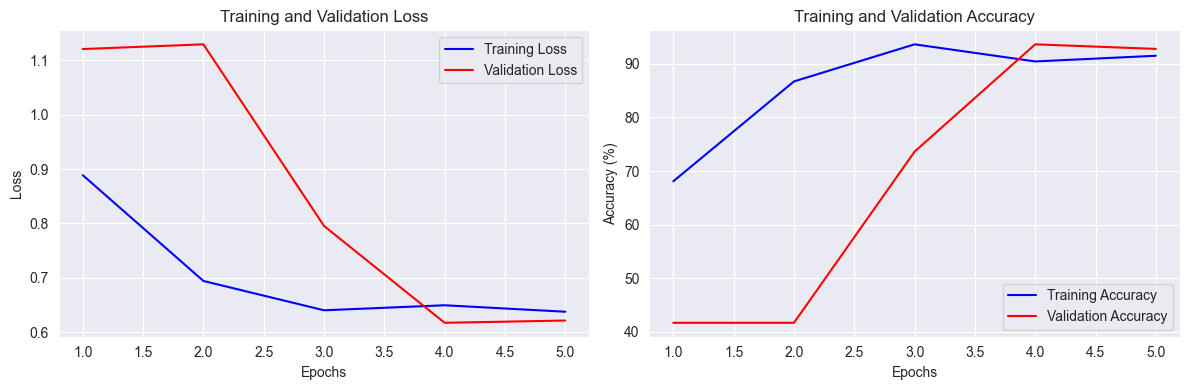

In [395]:
plot_metrics(training_losses, validation_losses, training_accuracies, validation_accuracies)

This looks like successful training. We can consider it to be the **best model**. The model is steadily improving its performance over the 5 epochs in the training and validation. The improvement was mainly because of scheduling and early stopping to follow the state of the model. We think that the model is not overfit and also not underfit. But there can be slightly visible that if the scheduler wasn't implemented, then there would be overfit. Because validation accuracy improved after third epoch. The gap between training and validation is insignificant, which is good.

Also, it is important to mention that in all trainings we used preprocessed data.
